<h1>CNN model</h1>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #only show errors (hide INFO and WARNING)

import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt

random.seed(1234)   
np.random.seed(1234)


<h3>Helper functions to plot loss/accuracy, and build/train/test models.</h3>

In [2]:
def plot_loss_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

def plot_accuracy_history(history):
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['accuracy'] + 1)))
  plt.plot(history['accuracy'], label="training", marker='o')
  plt.plot(history['val_accuracy'], label="validation", marker='o')
  plt.legend()
  plt.show()

In [25]:
def build_model(sample_size, num_of_features, dense_layers_unit_array=[], learningRate=0.001,
                activation="relu", isBatchNormalized=False, dropOutRate=0,
                startWithBatchNormalized=False,optimizer="Adam",
                conv_layers_filters_array=[],conv_kernel_size_array=[],conv_strides_array=[],
               ):
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    
    strategy = tf.distribute.MirroredStrategy(devices=None)
    print('Number of GPU/CPU: {}'.format(strategy.num_replicas_in_sync))
    
    print("num_of_dense_layers:",len(dense_layers_unit_array))
    
    for i, dense_layer_unit in enumerate(dense_layers_unit_array):       
        print("dense_layer["+str(i)+"]; unit:"+str(dense_layer_unit))      
        
        
    print("num_of_conv_layers:",len(conv_layers_filters_array))    
    for i, conv_layer_filters in enumerate(conv_layers_filters_array):       
        print("conv_layer_filters["+str(i)+"]; unit:"+str(conv_layer_filters))  
        print("conv_kernel["+str(i)+"]; unit:"+str(conv_kernel_size_array[i]))
        print("conv_strides["+str(i)+"]; unit:"+str(conv_strides_array[i]))
       
    print("learningRate:",learningRate)
    print("isBatchNormalized:",isBatchNormalized,"; dropOutRate:",dropOutRate)
    
    startWithBatchNormalized = startWithBatchNormalized or optimizer == "SGD"
    print("startWithBatchNormalized:",startWithBatchNormalized)
    print("optimizer:",optimizer,"; activation:",activation)
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)     
    np.random.seed(1234)
    random.seed(1234)
    
    with strategy.scope():   
        model = Sequential() 
        
        if startWithBatchNormalized:
            model.add(BatchNormalization())
        
        # Add Dense layers
        for i, conv_layer_filters in enumerate(conv_layers_filters_array):    
            model.add(tf.keras.layers.Conv1D(
            filters=conv_layer_filters,                
            kernel_size=conv_kernel_size_array[i],
            strides=conv_strides_array[i],
            padding='same',
            data_format='channels_last',
            name='conv_'+str(i),
            activation='relu'))
        
            model.add(tf.keras.layers.MaxPool1D(
                pool_size=2,
                name='pool_'+str(i))) 

        if len(conv_layers_filters_array) > 0:    
            model.add(Flatten()) 
        
        # Add Dense layers
        for i, dense_layer_unit in enumerate(dense_layers_unit_array):
            model.add(tf.keras.layers.Dense(
                units=dense_layer_unit,
                name='fc_'+str(i), 
                activation=activation))
            if isBatchNormalized:
                model.add(BatchNormalization())
            if dropOutRate > 0:
                model.add(Dropout(dropOutRate))

        model.add(Dense(4))
        model.add(Activation('softmax'))   

        model.build(input_shape=(None, sample_size, num_of_features))

        if optimizer=="Adam":
            opt = keras.optimizers.Adam(learning_rate=learningRate)
        elif optimizer=="SGD":
            opt = keras.optimizers.SGD(learning_rate=learningRate)
        else:
            opt = keras.optimizers.Adam(learning_rate=learningRate)    
        

        model.compile(optimizer=opt,
                      loss=['categorical_crossentropy'],
                      metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])    
    
    return model
    

In [24]:
def train_and_test_model(sample_size, num_of_features,
                         train_dataset, validate_dataset, x_train,
                         save_to, epoch = 2,
                         dense_layers_unit_array=[],
                         patience=10, epoch_denominator=10.,
                         isConstantLearningRate=False, learningRate=0.001,
                         activation="relu", isBatchNormalized=False,dropOutRate=0,
                         startWithBatchNormalized=False,optimizer="Adam",
                         conv_layers_filters_array=[],conv_kernel_size_array=[],conv_strides_array=[]
                        ):
    
    print("epoch:",epoch, "; epoch_denominator:",epoch_denominator) 
    print("patience:",patience,"; isConstantLearningRate:", isConstantLearningRate) 
    
    model = build_model(sample_size, num_of_features,
                        dense_layers_unit_array=dense_layers_unit_array, learningRate=learningRate,
                        activation=activation, isBatchNormalized=isBatchNormalized, dropOutRate=dropOutRate,
                        startWithBatchNormalized=startWithBatchNormalized,optimizer=optimizer,
                        conv_layers_filters_array=conv_layers_filters_array,
                        conv_kernel_size_array=conv_kernel_size_array,
                        conv_strides_array=conv_strides_array
                       )

    model.summary()
    tf.keras.utils.plot_model(model)  
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

    if isConstantLearningRate:  
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate)        
    else:  
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate * np.exp(-epoch / epoch_denominator))

    history = model.fit(train_dataset,
                        epochs=epoch,
                        validation_data=validate_dataset,
                        shuffle=True,
                        callbacks=[es,lr_schedule])

    history_data = pd.DataFrame(history.history)
    plot_loss_history(history_data)
    plot_accuracy_history(history_data)

    # test model
    test_results = model.evaluate(test_dataset)
    print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

    # show classification report
    y_predict = np.array(model.predict(test_dataset))
    y_predict = to_categorical(np.argmax(y_predict, axis=1), 4)
    print(classification_report(y_test, y_predict))
    
    print("Confusion matrix")
    print(confusion_matrix(y_test.values.argmax(axis=1), np.argmax(y_predict, axis=1)))


In [5]:
dataset = pd.read_csv('csv/out_gameemo_time_domain_simple.csv',  sep=',')

print('Shape of data: ', dataset.shape)

Shape of data:  (4284224, 15)


In [6]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

init_df = dataset.copy()

#HA_PV = high arousal, positive valence
#HA_NV = high arousal, negative valence
#LA_NV = low arousal, negative valence
#LA_PV = low arousal, positive valance
label_map = {1:"HA_PV", 2:"HA_NV", 3:"LA_NV", 4:"LA_PV"}

init_df["Label"] = init_df["Label"].map(label_map)


features = init_df.iloc[:, :-1]
label = init_df.iloc[:, -1:]

print('Shape of data: ', init_df.shape)
print('features.shape: ', features.shape)
print('label.shape: ', label.shape)

#######

y = label.to_numpy()
X = features.to_numpy()

# 38252 is the max sample size, data collected for one participant. Can choose smaller sample size that can
# divide 38252.
# 38252 can be divided by 73 or 131, 524
sample_size = int(38252/73)  
num_of_features = 14

train_dataset_percentage = 0.6

print("sample_size:",sample_size)
print("num_of_features:",num_of_features)

print("number of records:",X.shape[0])
total_samples_count = int(X.shape[0]/sample_size)

print("total_samples_count:", total_samples_count)


train_sample_count = int(total_samples_count * train_dataset_percentage)
validate_sample_count = int((total_samples_count - train_sample_count) * 0.5) # half of 40% = 20%
test_sample_count = total_samples_count - train_sample_count - validate_sample_count

train_size = int(train_sample_count * sample_size)
validate_size = int(validate_sample_count * sample_size)
test_size = int(test_sample_count * sample_size)

print("train size:", train_size)
print("validate size:", validate_size)
print("test size:", test_size)

X_train, X_validate, X_test = X[:train_size], X[train_size:train_size+validate_size], X[-test_size:]
y_train, y_validate, y_test = y[:train_size], y[train_size:train_size+validate_size], y[-test_size:]

X_train = X_train.reshape((train_sample_count,sample_size,num_of_features))
X_validate = X_validate.reshape((validate_sample_count,sample_size,num_of_features))
X_test = X_test.reshape((test_sample_count,sample_size,num_of_features))

print("X_train.shape after reshape:",X_train.shape)
print("X_validate.shape after reshape:",X_validate.shape)
print("X_test.shape after reshape:",X_test.shape)

#collapse y_train and y_test to the same X sample counts instead

y_train_collapsed = np.array([])
for i in range(len(y_train)):
    if (i % sample_size == 0):
        y_train_collapsed = np.append(y_train_collapsed, (y_train[i]))
        
print("y_train_collapsed shape:",y_train_collapsed.shape)        

y_validate_collapsed = np.array([])
for i in range(len(y_validate)):
    if (i % sample_size == 0):
        y_validate_collapsed = np.append(y_validate_collapsed, (y_validate[i]))
        
print("y_validate_collapsed shape:",y_validate_collapsed.shape)

y_test_collapsed = np.array([])
for i in range(len(y_test)):
    if (i % sample_size == 0):
        y_test_collapsed = np.append(y_test_collapsed, (y_test[i]))
        
print("y_test_collapsed shape:",y_test_collapsed.shape)    


y_train = pd.get_dummies(y_train_collapsed)
y_validate = pd.get_dummies(y_validate_collapsed)
y_test = pd.get_dummies(y_test_collapsed)

print("y_train.shape:", y_train.shape)
print("y_validate.shape:", y_validate.shape)
print("y_test.shape:", y_test.shape)

print("y_train:")
print(y_train[:5])

#######
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validate_dataset = tf.data.Dataset.from_tensor_slices((X_validate, y_validate))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_dataset.with_options(options)
validate_dataset.with_options(options)
test_dataset.with_options(options)

batch_size = 30
train_dataset = train_dataset.batch(batch_size)
validate_dataset = validate_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)


Shape of data:  (4284224, 15)
features.shape:  (4284224, 14)
label.shape:  (4284224, 1)
sample_size: 524
num_of_features: 14
number of records: 4284224
total_samples_count: 8176
train size: 2570220
validate size: 856740
test size: 857264
X_train.shape after reshape: (4905, 524, 14)
X_validate.shape after reshape: (1635, 524, 14)
X_test.shape after reshape: (1636, 524, 14)
y_train_collapsed shape: (4905,)
y_validate_collapsed shape: (1635,)
y_test_collapsed shape: (1636,)
y_train.shape: (4905, 4)
y_validate.shape: (1635, 4)
y_test.shape: (1636, 4)
y_train:
   HA_NV  HA_PV  LA_NV  LA_PV
0      1      0      0      0
1      1      0      0      0
2      1      0      0      0
3      1      0      0      0
4      1      0      0      0


<h3>Manual runs to get a feel of the hyperparameters</h3>

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 0
num_of_conv_layers: 1
conv_layer_filters[0]; unit:50
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv1D)              (None, 524, 50)           2150      
_________________________________________________________________
pool_0 (MaxPooling1D)        (None, 262, 50)           0         
_________________________________________________________________
flatten (Flatten)            (None, 13100)             0         
_______________

164/164 [==============================] - 2s 10ms/step - loss: 12.6535 - accuracy: 0.3930 - precision: 0.4569 - recall: 0.3154 - val_loss: 59.4205 - val_accuracy: 0.2924 - val_precision: 0.3081 - val_recall: 0.2587
Epoch 30/40
164/164 [==============================] - 2s 9ms/step - loss: 10.6019 - accuracy: 0.3912 - precision: 0.4619 - recall: 0.3073 - val_loss: 55.1046 - val_accuracy: 0.2703 - val_precision: 0.2896 - val_recall: 0.2404
Epoch 31/40
164/164 [==============================] - 2s 10ms/step - loss: 7.6854 - accuracy: 0.3977 - precision: 0.4732 - recall: 0.3109 - val_loss: 45.3876 - val_accuracy: 0.2869 - val_precision: 0.3078 - val_recall: 0.2483
Epoch 32/40
164/164 [==============================] - 2s 10ms/step - loss: 6.6383 - accuracy: 0.3894 - precision: 0.4702 - recall: 0.2873 - val_loss: 42.2258 - val_accuracy: 0.2526 - val_precision: 0.2713 - val_recall: 0.2159
Epoch 33/40
164/164 [==============================] - 2s 9ms/step - loss: 5.4860 - accuracy: 0.3996 - 

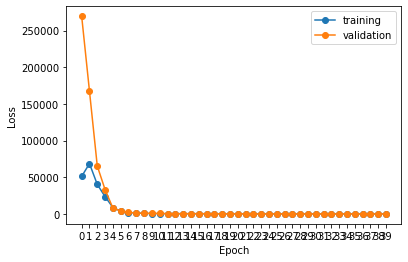

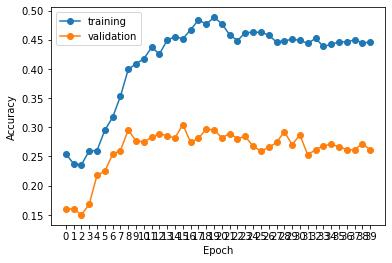

55/55 [==============================] - 0s 6ms/step - loss: 31.4341 - accuracy: 0.2482 - precision: 0.2869 - recall: 0.1840

Test Acc. 24.82%
              precision    recall  f1-score   support

           0       0.31      0.21      0.25       438
           1       0.28      0.25      0.27       395
           2       0.27      0.14      0.18       438
           3       0.20      0.42      0.27       365

   micro avg       0.25      0.25      0.25      1636
   macro avg       0.27      0.26      0.24      1636
weighted avg       0.27      0.25      0.24      1636
 samples avg       0.25      0.25      0.25      1636

Confusion matrix
[[ 92  65  45 236]
 [ 54 100  50 191]
 [ 88 115  61 174]
 [ 61  77  74 153]]


In [26]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[], learningRate=0.1,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[50],
                     conv_kernel_size_array=[3],
                     conv_strides_array=[1]
                    )

Try increase the epoch to give it more time to run, see if it can get higher accuracy.
Result: no improvement.

epoch: 80 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 0
num_of_conv_layers: 1
conv_layer_filters[0]; unit:50
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv1D)              (None, 524, 50)           2150      
_________________________________________________________________
pool_0 (MaxPooling1D)        (None, 262, 50)           0         
_________________________________________________________________
flatten (Flatten)            (None, 13100)             0         
_______________

164/164 [==============================] - 2s 9ms/step - loss: 8.4146 - accuracy: 0.3609 - precision: 0.4447 - recall: 0.2478 - val_loss: 49.6659 - val_accuracy: 0.2746 - val_precision: 0.2918 - val_recall: 0.2232
Epoch 30/80
164/164 [==============================] - 1s 9ms/step - loss: 8.1424 - accuracy: 0.3625 - precision: 0.4483 - recall: 0.2429 - val_loss: 48.6853 - val_accuracy: 0.2612 - val_precision: 0.2725 - val_recall: 0.2037
Epoch 31/80
164/164 [==============================] - 2s 9ms/step - loss: 7.4274 - accuracy: 0.3522 - precision: 0.4557 - recall: 0.2358 - val_loss: 42.2000 - val_accuracy: 0.2428 - val_precision: 0.2491 - val_recall: 0.1780
Epoch 32/80
164/164 [==============================] - 2s 10ms/step - loss: 5.6976 - accuracy: 0.3541 - precision: 0.4600 - recall: 0.2213 - val_loss: 38.3610 - val_accuracy: 0.2667 - val_precision: 0.2722 - val_recall: 0.1914
Epoch 33/80
164/164 [==============================] - 2s 9ms/step - loss: 6.5046 - accuracy: 0.3411 - prec

164/164 [==============================] - 2s 10ms/step - loss: 1.2289 - accuracy: 0.4316 - precision: 0.7655 - recall: 0.2394 - val_loss: 20.3206 - val_accuracy: 0.2575 - val_precision: 0.2667 - val_recall: 0.1535
Epoch 66/80
164/164 [==============================] - 2s 10ms/step - loss: 1.2251 - accuracy: 0.4310 - precision: 0.7696 - recall: 0.2402 - val_loss: 20.2640 - val_accuracy: 0.2569 - val_precision: 0.2671 - val_recall: 0.1529
Epoch 67/80
164/164 [==============================] - 2s 9ms/step - loss: 1.2193 - accuracy: 0.4328 - precision: 0.7752 - recall: 0.2411 - val_loss: 20.2569 - val_accuracy: 0.2563 - val_precision: 0.2658 - val_recall: 0.1517
Epoch 68/80
164/164 [==============================] - 2s 10ms/step - loss: 1.2169 - accuracy: 0.4329 - precision: 0.7782 - recall: 0.2408 - val_loss: 20.2612 - val_accuracy: 0.2557 - val_precision: 0.2634 - val_recall: 0.1505
Epoch 69/80
164/164 [==============================] - 2s 10ms/step - loss: 1.2128 - accuracy: 0.4340 - p

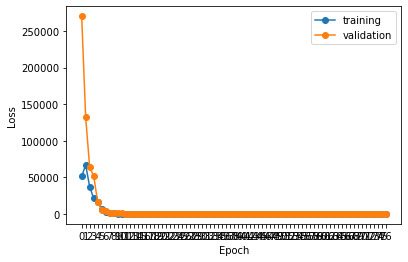

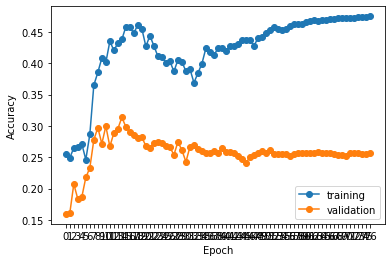

55/55 [==============================] - 0s 6ms/step - loss: 18.3588 - accuracy: 0.2482 - precision: 0.2620 - recall: 0.1333

Test Acc. 24.82%
              precision    recall  f1-score   support

           0       0.30      0.20      0.24       438
           1       0.25      0.17      0.20       395
           2       0.25      0.50      0.33       438
           3       0.18      0.08      0.11       365

   micro avg       0.25      0.25      0.25      1636
   macro avg       0.24      0.24      0.22      1636
weighted avg       0.24      0.25      0.23      1636
 samples avg       0.25      0.25      0.25      1636

Confusion matrix
[[ 87  45 262  44]
 [ 58  68 221  48]
 [ 90  82 221  45]
 [ 59  79 197  30]]


In [27]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, save_to= './', epoch = 80, 
                     dense_layers_unit_array=[], learningRate=0.1,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[50],
                     conv_kernel_size_array=[3],
                     conv_strides_array=[1]
                    )

Try adding dense layer. Result: no improvement

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_conv_layers: 1
conv_layer_filters[0]; unit:50
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv1D)              (None, 524, 50)           2150      
_________________________________________________________________
pool_0 (MaxPooling1D)        (None, 262, 50)           0         
_________________________________________________________________
flatten (Flatten)            (None, 13100)             0

Epoch 27/40
164/164 [==============================] - 2s 11ms/step - loss: 1.3987 - accuracy: 0.2294 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4055 - val_accuracy: 0.1602 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 28/40
164/164 [==============================] - 2s 11ms/step - loss: 1.3981 - accuracy: 0.2294 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4053 - val_accuracy: 0.1602 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 29/40
164/164 [==============================] - 2s 11ms/step - loss: 1.3975 - accuracy: 0.2294 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4052 - val_accuracy: 0.1602 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 30/40
164/164 [==============================] - 2s 11ms/step - loss: 1.3970 - accuracy: 0.2294 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4051 - val_accuracy: 0.1602 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 31/40
164/164 [===========

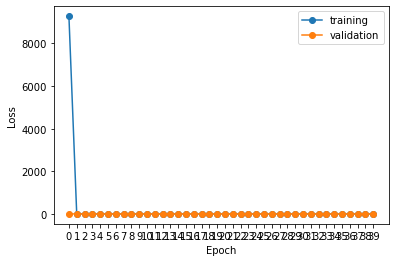

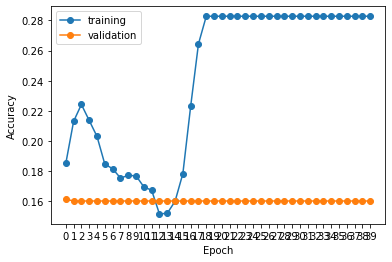

55/55 [==============================] - 0s 6ms/step - loss: 1.3902 - accuracy: 0.2414 - precision: 0.0000e+00 - recall: 0.0000e+00

Test Acc. 24.14%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       438
           1       0.24      1.00      0.39       395
           2       0.00      0.00      0.00       438
           3       0.00      0.00      0.00       365

   micro avg       0.24      0.24      0.24      1636
   macro avg       0.06      0.25      0.10      1636
weighted avg       0.06      0.24      0.09      1636
 samples avg       0.24      0.24      0.24      1636

Confusion matrix
[[  0 438   0   0]
 [  0 395   0   0]
 [  0 438   0   0]
 [  0 365   0   0]]


/home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.1,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[50],
                     conv_kernel_size_array=[3],
                     conv_strides_array=[1]
                    )

Try add one more Conv layer. Results: no improvement.

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 0
num_of_conv_layers: 2
conv_layer_filters[0]; unit:50
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:50
conv_kernel[1]; unit:3
conv_strides[1]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv1D)              (None, 524, 50)           2150      
_________________________________________________________________
pool_0 (MaxPooling1D)        (None, 262, 50)           0         
_________________________________________________________________
con

164/164 [==============================] - 2s 10ms/step - loss: 1.3994 - accuracy: 0.2294 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4057 - val_accuracy: 0.1602 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 27/40
164/164 [==============================] - 2s 10ms/step - loss: 1.3987 - accuracy: 0.2294 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4055 - val_accuracy: 0.1602 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 28/40
164/164 [==============================] - 2s 10ms/step - loss: 1.3981 - accuracy: 0.2294 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4053 - val_accuracy: 0.1602 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 29/40
164/164 [==============================] - 2s 10ms/step - loss: 1.3975 - accuracy: 0.2294 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4052 - val_accuracy: 0.1602 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 30/40
164/164 [=======================

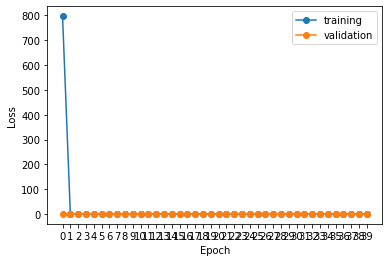

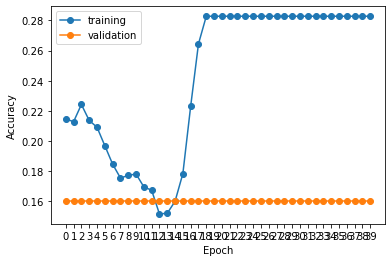

55/55 [==============================] - 1s 6ms/step - loss: 1.3902 - accuracy: 0.2414 - precision: 0.0000e+00 - recall: 0.0000e+00

Test Acc. 24.14%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       438
           1       0.24      1.00      0.39       395
           2       0.00      0.00      0.00       438
           3       0.00      0.00      0.00       365

   micro avg       0.24      0.24      0.24      1636
   macro avg       0.06      0.25      0.10      1636
weighted avg       0.06      0.24      0.09      1636
 samples avg       0.24      0.24      0.24      1636

Confusion matrix
[[  0 438   0   0]
 [  0 395   0   0]
 [  0 438   0   0]
 [  0 365   0   0]]


/home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[], learningRate=0.1,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[50,50],
                     conv_kernel_size_array=[3,3],
                     conv_strides_array=[1,1]
                    )

Try 1 Conv layer but more filters. Results: accuracy increases from ~25% to 37%. No early stop so it seems we can increase epoch.

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 0
num_of_conv_layers: 1
conv_layer_filters[0]; unit:512
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv1D)              (None, 524, 512)          22016     
_________________________________________________________________
pool_0 (MaxPooling1D)        (None, 262, 512)          0         
_________________________________________________________________
flatten (Flatten)            (None, 134144)            0         
______________

Epoch 29/40
164/164 [==============================] - 2s 10ms/step - loss: 28.2870 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - val_loss: 10291.7578 - val_accuracy: 0.4489 - val_precision: 0.4489 - val_recall: 0.4489
Epoch 30/40
164/164 [==============================] - 2s 10ms/step - loss: 35.9015 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - val_loss: 10246.1309 - val_accuracy: 0.4483 - val_precision: 0.4483 - val_recall: 0.4483
Epoch 31/40
164/164 [==============================] - 2s 11ms/step - loss: 18.3213 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - val_loss: 10182.8662 - val_accuracy: 0.4557 - val_precision: 0.4557 - val_recall: 0.4557
Epoch 32/40
164/164 [==============================] - 2s 11ms/step - loss: 9.6545 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - val_loss: 10188.8740 - val_accuracy: 0.4495 - val_precision: 0.4495 - val_recall: 0.4495
Epoch 33/40
164/164 [==============================] - 2s 11ms/step - loss: 1

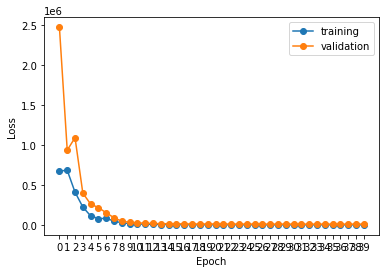

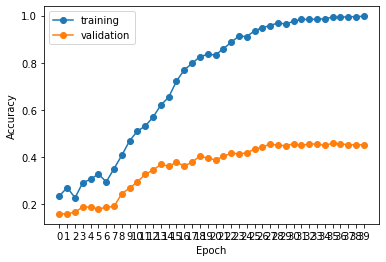

55/55 [==============================] - 1s 6ms/step - loss: 13191.6855 - accuracy: 0.3704 - precision: 0.3704 - recall: 0.3704

Test Acc. 37.04%
              precision    recall  f1-score   support

           0       0.38      0.39      0.38       438
           1       0.45      0.54      0.49       395
           2       0.28      0.24      0.26       438
           3       0.35      0.32      0.33       365

   micro avg       0.37      0.37      0.37      1636
   macro avg       0.36      0.37      0.37      1636
weighted avg       0.36      0.37      0.37      1636
 samples avg       0.37      0.37      0.37      1636

Confusion matrix
[[170  82  98  88]
 [ 55 212  58  70]
 [145 121 106  66]
 [ 78  53 116 118]]


In [30]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[], learningRate=0.1,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[512],
                     conv_kernel_size_array=[3],
                     conv_strides_array=[1]
                    )

Try 1 conv layer and more filters and longer epoch. Result: early stop this time, no improvements. validation accuracy almost maxes out.

epoch: 80 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 0
num_of_conv_layers: 1
conv_layer_filters[0]; unit:512
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv1D)              (None, 524, 512)          22016     
_________________________________________________________________
pool_0 (MaxPooling1D)        (None, 262, 512)          0         
_________________________________________________________________
flatten (Flatten)            (None, 134144)            0         
______________

Epoch 30/80
164/164 [==============================] - 2s 10ms/step - loss: 31.8714 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - val_loss: 9995.5488 - val_accuracy: 0.4404 - val_precision: 0.4404 - val_recall: 0.4404
Epoch 31/80
164/164 [==============================] - 2s 11ms/step - loss: 11.9006 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - val_loss: 10040.1152 - val_accuracy: 0.4398 - val_precision: 0.4398 - val_recall: 0.4398
Epoch 32/80
164/164 [==============================] - 2s 10ms/step - loss: 7.5833 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - val_loss: 10031.0039 - val_accuracy: 0.4373 - val_precision: 0.4373 - val_recall: 0.4373
Epoch 33/80
164/164 [==============================] - 2s 10ms/step - loss: 5.3411 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - val_loss: 10009.7227 - val_accuracy: 0.4410 - val_precision: 0.4410 - val_recall: 0.4410
Epoch 34/80
164/164 [==============================] - 2s 10ms/step - loss: 4.4

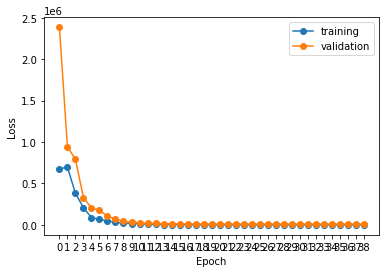

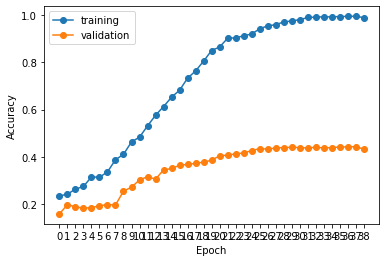

55/55 [==============================] - 0s 6ms/step - loss: 12141.2568 - accuracy: 0.3533 - precision: 0.3533 - recall: 0.3533

Test Acc. 35.33%
              precision    recall  f1-score   support

           0       0.38      0.34      0.36       438
           1       0.40      0.52      0.45       395
           2       0.28      0.25      0.26       438
           3       0.34      0.32      0.33       365

   micro avg       0.35      0.35      0.35      1636
   macro avg       0.35      0.36      0.35      1636
weighted avg       0.35      0.35      0.35      1636
 samples avg       0.35      0.35      0.35      1636

Confusion matrix
[[150  89 108  91]
 [ 50 204  67  74]
 [121 146 109  62]
 [ 71  68 111 115]]


In [31]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, save_to= './', epoch = 80, 
                     dense_layers_unit_array=[], learningRate=0.1,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[512],
                     conv_kernel_size_array=[3],
                     conv_strides_array=[1]
                    )

Try 1 conv layer and even more filters. Results: accuracy increase from 37% to 39%

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 0
num_of_conv_layers: 1
conv_layer_filters[0]; unit:1024
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv1D)              (None, 524, 1024)         44032     
_________________________________________________________________
pool_0 (MaxPooling1D)        (None, 262, 1024)         0         
_________________________________________________________________
flatten (Flatten)            (None, 268288)            0         
_____________

164/164 [==============================] - 2s 12ms/step - loss: 44.5068 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - val_loss: 17218.5273 - val_accuracy: 0.4648 - val_precision: 0.4648 - val_recall: 0.4648
Epoch 30/40
164/164 [==============================] - 2s 12ms/step - loss: 58.6835 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - val_loss: 17137.6738 - val_accuracy: 0.4642 - val_precision: 0.4642 - val_recall: 0.4642
Epoch 31/40
164/164 [==============================] - 2s 12ms/step - loss: 27.9259 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - val_loss: 17028.1582 - val_accuracy: 0.4673 - val_precision: 0.4673 - val_recall: 0.4673
Epoch 32/40
164/164 [==============================] - 2s 12ms/step - loss: 13.9270 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - val_loss: 17001.3789 - val_accuracy: 0.4624 - val_precision: 0.4624 - val_recall: 0.4624
Epoch 33/40
164/164 [==============================] - 2s 12ms/step - loss: 8.4874 - acc

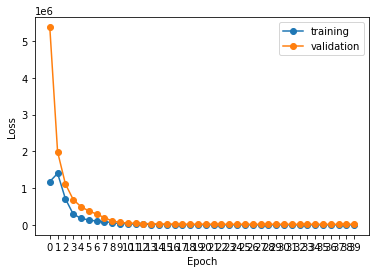

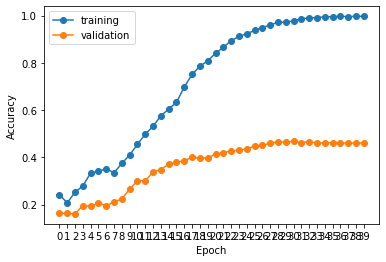

55/55 [==============================] - 1s 7ms/step - loss: 22180.5430 - accuracy: 0.3967 - precision: 0.3967 - recall: 0.3967

Test Acc. 39.67%
              precision    recall  f1-score   support

           0       0.41      0.39      0.40       438
           1       0.47      0.57      0.52       395
           2       0.31      0.25      0.28       438
           3       0.37      0.39      0.38       365

   micro avg       0.40      0.40      0.40      1636
   macro avg       0.39      0.40      0.39      1636
weighted avg       0.39      0.40      0.39      1636
 samples avg       0.40      0.40      0.40      1636

Confusion matrix
[[172  78  89  99]
 [ 43 226  49  77]
 [138 123 110  67]
 [ 64  49 111 141]]


In [32]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[], learningRate=0.1,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[1024],
                     conv_kernel_size_array=[3],
                     conv_strides_array=[1]
                    )

Try 1 conv layer and even more filters than last one. Results: worse than before.

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 0
num_of_conv_layers: 1
conv_layer_filters[0]; unit:2048
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv1D)              (None, 524, 2048)         88064     
_________________________________________________________________
pool_0 (MaxPooling1D)        (None, 262, 2048)         0         
_________________________________________________________________
flatten (Flatten)            (None, 536576)            0         
_____________

164/164 [==============================] - 2s 15ms/step - loss: 96.0326 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - val_loss: 41859.6094 - val_accuracy: 0.4440 - val_precision: 0.4440 - val_recall: 0.4440
Epoch 30/40
164/164 [==============================] - 2s 15ms/step - loss: 26.1044 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - val_loss: 41738.1562 - val_accuracy: 0.4471 - val_precision: 0.4471 - val_recall: 0.4471
Epoch 31/40
164/164 [==============================] - 2s 15ms/step - loss: 15.2113 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - val_loss: 41816.9258 - val_accuracy: 0.4483 - val_precision: 0.4483 - val_recall: 0.4483
Epoch 32/40
164/164 [==============================] - 2s 15ms/step - loss: 11.8896 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - val_loss: 41695.9609 - val_accuracy: 0.4483 - val_precision: 0.4483 - val_recall: 0.4483
Epoch 33/40
164/164 [==============================] - 2s 15ms/step - loss: 7.6975 - acc

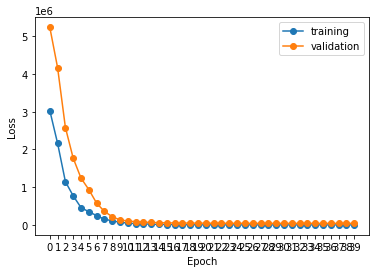

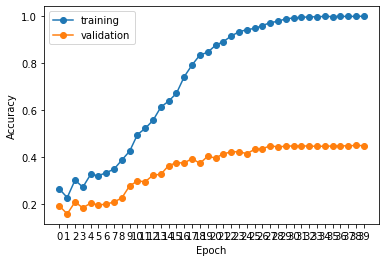

55/55 [==============================] - 1s 8ms/step - loss: 53026.8867 - accuracy: 0.3796 - precision: 0.3796 - recall: 0.3796

Test Acc. 37.96%
              precision    recall  f1-score   support

           0       0.39      0.32      0.35       438
           1       0.49      0.55      0.52       395
           2       0.26      0.26      0.26       438
           3       0.37      0.41      0.39       365

   micro avg       0.38      0.38      0.38      1636
   macro avg       0.38      0.39      0.38      1636
weighted avg       0.38      0.38      0.38      1636
 samples avg       0.38      0.38      0.38      1636

Confusion matrix
[[139  72 117 110]
 [ 43 218  59  75]
 [136 120 115  67]
 [ 37  34 145 149]]


In [33]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[], learningRate=0.1,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[2048],
                     conv_kernel_size_array=[3],
                     conv_strides_array=[1]
                    )

Try 2 conv layer with more filters.

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 0
num_of_conv_layers: 2
conv_layer_filters[0]; unit:1024
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:512
conv_kernel[1]; unit:3
conv_strides[1]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv1D)              (None, 524, 1024)         44032     
_________________________________________________________________
pool_0 (MaxPooling1D)        (None, 262, 1024)         0         
_________________________________________________________________


164/164 [==============================] - 3s 17ms/step - loss: 1.3987 - accuracy: 0.2294 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4055 - val_accuracy: 0.1602 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 28/40
164/164 [==============================] - 3s 17ms/step - loss: 1.3981 - accuracy: 0.2294 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4053 - val_accuracy: 0.1602 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 29/40
164/164 [==============================] - 3s 17ms/step - loss: 1.3975 - accuracy: 0.2294 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4052 - val_accuracy: 0.1602 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 30/40
164/164 [==============================] - 3s 17ms/step - loss: 1.3970 - accuracy: 0.2294 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4051 - val_accuracy: 0.1602 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 31/40
164/164 [=======================

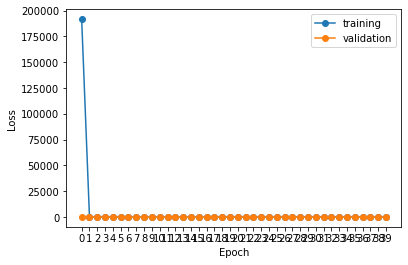

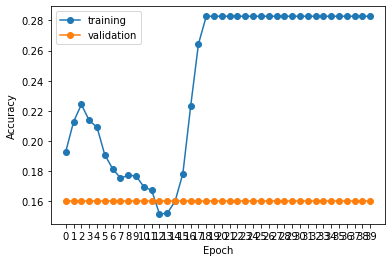

55/55 [==============================] - 1s 8ms/step - loss: 1.3902 - accuracy: 0.2414 - precision: 0.0000e+00 - recall: 0.0000e+00

Test Acc. 24.14%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       438
           1       0.24      1.00      0.39       395
           2       0.00      0.00      0.00       438
           3       0.00      0.00      0.00       365

   micro avg       0.24      0.24      0.24      1636
   macro avg       0.06      0.25      0.10      1636
weighted avg       0.06      0.24      0.09      1636
 samples avg       0.24      0.24      0.24      1636

Confusion matrix
[[  0 438   0   0]
 [  0 395   0   0]
 [  0 438   0   0]
 [  0 365   0   0]]


/home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[], learningRate=0.1,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[1024,512],
                     conv_kernel_size_array=[3,3],
                     conv_strides_array=[1,1]
                    )

Try swapping the 2 conv layers, the first one has fewer filters. Results: no improvement

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 0
num_of_conv_layers: 2
conv_layer_filters[0]; unit:512
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:1024
conv_kernel[1]; unit:3
conv_strides[1]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv1D)              (None, 524, 512)          22016     
_________________________________________________________________
pool_0 (MaxPooling1D)        (None, 262, 512)          0         
_________________________________________________________________


164/164 [==============================] - 3s 17ms/step - loss: 1.3987 - accuracy: 0.2294 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4055 - val_accuracy: 0.1602 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 28/40
164/164 [==============================] - 3s 17ms/step - loss: 1.3981 - accuracy: 0.2294 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4053 - val_accuracy: 0.1602 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 29/40
164/164 [==============================] - 3s 17ms/step - loss: 1.3975 - accuracy: 0.2294 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4052 - val_accuracy: 0.1602 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 30/40
164/164 [==============================] - 3s 17ms/step - loss: 1.3970 - accuracy: 0.2294 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4051 - val_accuracy: 0.1602 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 31/40
164/164 [=======================

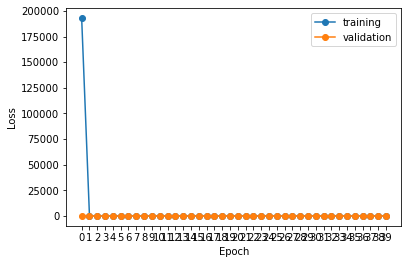

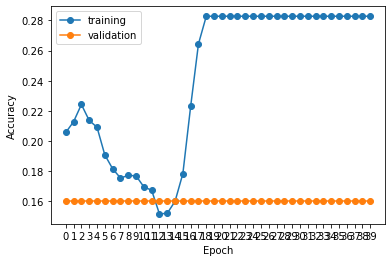

55/55 [==============================] - 1s 8ms/step - loss: 1.3902 - accuracy: 0.2414 - precision: 0.0000e+00 - recall: 0.0000e+00

Test Acc. 24.14%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       438
           1       0.24      1.00      0.39       395
           2       0.00      0.00      0.00       438
           3       0.00      0.00      0.00       365

   micro avg       0.24      0.24      0.24      1636
   macro avg       0.06      0.25      0.10      1636
weighted avg       0.06      0.24      0.09      1636
 samples avg       0.24      0.24      0.24      1636

Confusion matrix
[[  0 438   0   0]
 [  0 395   0   0]
 [  0 438   0   0]
 [  0 365   0   0]]


/home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[], learningRate=0.1,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[512,1024],
                     conv_kernel_size_array=[3,3],
                     conv_strides_array=[1,1]
                    )

Try two conv layers with lots of filters, and 1 dense layer. Results: loss and accuracy moves very slowly.

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:128
num_of_conv_layers: 2
conv_layer_filters[0]; unit:512
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:1024
conv_kernel[1]; unit:3
conv_strides[1]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv1D)              (None, 524, 512)          22016     
_________________________________________________________________
pool_0 (MaxPooling1D)        (None, 262, 512)          0         
_________________________________________

Epoch 26/40
164/164 [==============================] - 3s 21ms/step - loss: 1.3994 - accuracy: 0.2294 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4057 - val_accuracy: 0.1602 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 27/40
164/164 [==============================] - 3s 21ms/step - loss: 1.3987 - accuracy: 0.2294 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4055 - val_accuracy: 0.1602 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 28/40
164/164 [==============================] - 3s 20ms/step - loss: 1.3981 - accuracy: 0.2294 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4053 - val_accuracy: 0.1602 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 29/40
164/164 [==============================] - 3s 21ms/step - loss: 1.3975 - accuracy: 0.2294 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4052 - val_accuracy: 0.1602 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 30/40
164/164 [===========

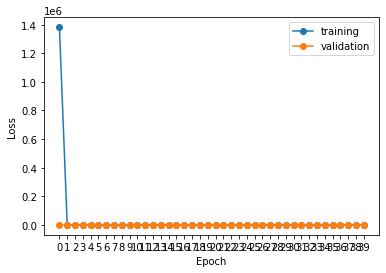

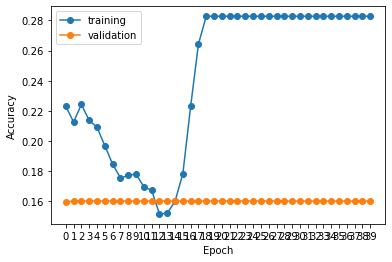

55/55 [==============================] - 1s 8ms/step - loss: 1.3902 - accuracy: 0.2414 - precision: 0.0000e+00 - recall: 0.0000e+00

Test Acc. 24.14%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       438
           1       0.24      1.00      0.39       395
           2       0.00      0.00      0.00       438
           3       0.00      0.00      0.00       365

   micro avg       0.24      0.24      0.24      1636
   macro avg       0.06      0.25      0.10      1636
weighted avg       0.06      0.24      0.09      1636
 samples avg       0.24      0.24      0.24      1636

Confusion matrix
[[  0 438   0   0]
 [  0 395   0   0]
 [  0 438   0   0]
 [  0 365   0   0]]


/home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[128], learningRate=0.1,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[512,1024],
                     conv_kernel_size_array=[3,3],
                     conv_strides_array=[1,1]
                    )

Try 2 conv layers and 2 dense layers. Results: no improvement

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 2
dense_layer[0]; unit:128
dense_layer[1]; unit:128
num_of_conv_layers: 2
conv_layer_filters[0]; unit:512
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:1024
conv_kernel[1]; unit:3
conv_strides[1]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv1D)              (None, 524, 512)          22016     
_________________________________________________________________
pool_0 (MaxPooling1D)        (None, 262, 512)          0         
________________

Epoch 25/40
164/164 [==============================] - 3s 21ms/step - loss: 1.4002 - accuracy: 0.2294 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4059 - val_accuracy: 0.1602 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 26/40
164/164 [==============================] - 3s 21ms/step - loss: 1.3994 - accuracy: 0.2294 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4057 - val_accuracy: 0.1602 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 27/40
164/164 [==============================] - 3s 21ms/step - loss: 1.3987 - accuracy: 0.2294 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4055 - val_accuracy: 0.1602 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 28/40
164/164 [==============================] - 3s 21ms/step - loss: 1.3981 - accuracy: 0.2294 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4053 - val_accuracy: 0.1602 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 29/40
164/164 [===========

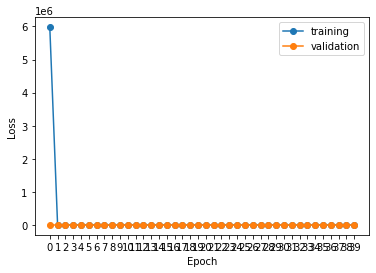

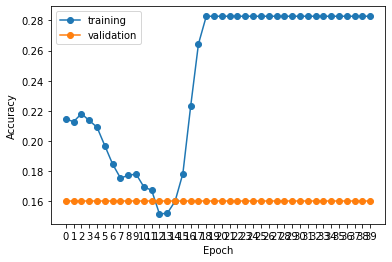

55/55 [==============================] - 1s 8ms/step - loss: 1.3902 - accuracy: 0.2414 - precision: 0.0000e+00 - recall: 0.0000e+00

Test Acc. 24.14%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       438
           1       0.24      1.00      0.39       395
           2       0.00      0.00      0.00       438
           3       0.00      0.00      0.00       365

   micro avg       0.24      0.24      0.24      1636
   macro avg       0.06      0.25      0.10      1636
weighted avg       0.06      0.24      0.09      1636
 samples avg       0.24      0.24      0.24      1636

Confusion matrix
[[  0 438   0   0]
 [  0 395   0   0]
 [  0 438   0   0]
 [  0 365   0   0]]


/home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[128,128], learningRate=0.1,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[512,1024],
                     conv_kernel_size_array=[3,3],
                     conv_strides_array=[1,1]
                    )

Try 2 conv layers and 2 dense layers. Try lower learning rate?

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 2
dense_layer[0]; unit:128
dense_layer[1]; unit:128
num_of_conv_layers: 2
conv_layer_filters[0]; unit:512
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:1024
conv_kernel[1]; unit:3
conv_strides[1]; unit:1
learningRate: 0.01
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv1D)              (None, 524, 512)          22016     
_________________________________________________________________
pool_0 (MaxPooling1D)        (None, 262, 512)          0         
_______________

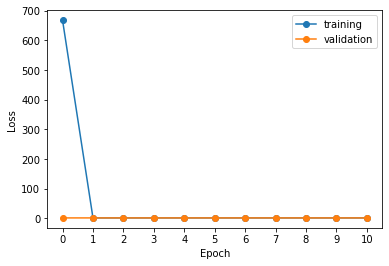

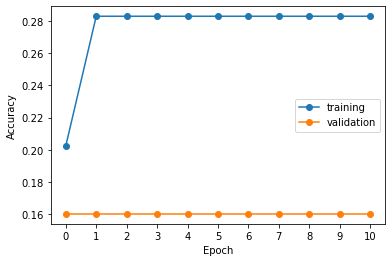

55/55 [==============================] - 1s 8ms/step - loss: 1.3903 - accuracy: 0.2414 - precision: 0.0000e+00 - recall: 0.0000e+00

Test Acc. 24.14%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       438
           1       0.24      1.00      0.39       395
           2       0.00      0.00      0.00       438
           3       0.00      0.00      0.00       365

   micro avg       0.24      0.24      0.24      1636
   macro avg       0.06      0.25      0.10      1636
weighted avg       0.06      0.24      0.09      1636
 samples avg       0.24      0.24      0.24      1636

Confusion matrix
[[  0 438   0   0]
 [  0 395   0   0]
 [  0 438   0   0]
 [  0 365   0   0]]


/home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[128,128], learningRate=0.01,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[512,1024],
                     conv_kernel_size_array=[3,3],
                     conv_strides_array=[1,1]
                    )

In [ ]:
Try 2 conv layers and 2 dense layers with even more units. Results: no improvements.

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 2
dense_layer[0]; unit:1024
dense_layer[1]; unit:1024
num_of_conv_layers: 2
conv_layer_filters[0]; unit:512
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:1024
conv_kernel[1]; unit:3
conv_strides[1]; unit:1
learningRate: 0.01
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv1D)              (None, 524, 512)          22016     
_________________________________________________________________
pool_0 (MaxPooling1D)        (None, 262, 512)          0         
_____________

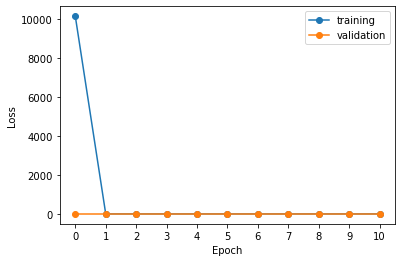

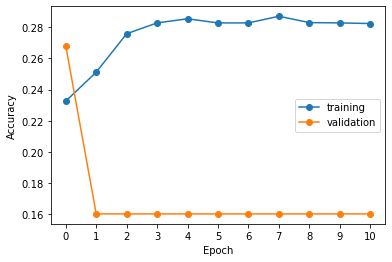

55/55 [==============================] - 1s 10ms/step - loss: 1.3904 - accuracy: 0.2414 - precision: 0.0000e+00 - recall: 0.0000e+00

Test Acc. 24.14%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       438
           1       0.24      1.00      0.39       395
           2       0.00      0.00      0.00       438
           3       0.00      0.00      0.00       365

   micro avg       0.24      0.24      0.24      1636
   macro avg       0.06      0.25      0.10      1636
weighted avg       0.06      0.24      0.09      1636
 samples avg       0.24      0.24      0.24      1636

Confusion matrix
[[  0 438   0   0]
 [  0 395   0   0]
 [  0 438   0   0]
 [  0 365   0   0]]


/home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[1024,1024], learningRate=0.01,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[512,1024],
                     conv_kernel_size_array=[3,3],
                     conv_strides_array=[1,1]
                    )

<h3>Conclusion</h3>

Manual tuning on CNN: 39% accuracy </br>
num_of_dense_layers: 0 </br>
num_of_conv_layers: 1 </br>
conv_layer_filters[0]; unit:1024 </br>
conv_kernel[0]; unit:3 </br>
conv_strides[0]; unit:1 </br>
learningRate: 0.1 </br>
isBatchNormalized: False </br>
dropOutRate: 0.5 </br>
startWithBatchNormalized: False </br>
optimizer: Adam </br>
activation: relu </br>
